In [138]:
# import the necessary libraries
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset

# import dataloader class
from torch.utils.data import DataLoader

from torchvision import transforms, datasets

# import visualisation tool
import matplotlib.pyplot as plt

# import time to time the training
import time

# import os for image loading outside torch
import os


In [139]:
# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# define the dataset path
dataset_path = 'archive'
train_path = dataset_path + '/Training'
test_path = dataset_path + '/Testing'

# define the transforms
data_transform = transforms.Compose(
    [transforms.Resize((256, 256)), 
    transforms.ToTensor()])

# define the datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform)

# define the dataloaders with the transforms
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

# move to gpu if available
if torch.cuda.is_available():
    train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
    test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

Using device: cuda


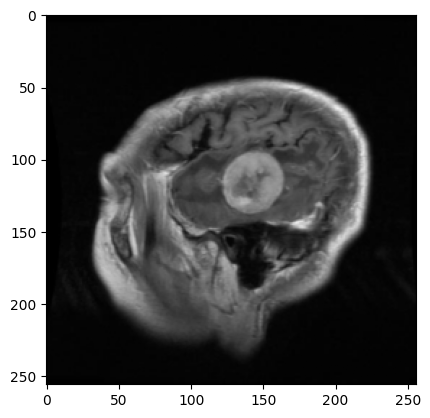

In [ ]:
# show the first image in the train_loader dataset
data = next(iter(train_loader))
img = data[0][0]
plt.imshow(img.permute(1, 2, 0))

### Attempt 1: Simple CNN model with one Conv2D and one FC layer

In [ ]:
# simple CNN model with one convolutional layer and one fully connected layer

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*128*128, 4))

# move the model to the GPU if available
model.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
train_temp = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(n_epochs):
    model.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()}')
   

/home/adam/.conda/envs/torch/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/10 - Loss: 0.5902161002159119
Epoch 2/10 - Loss: 0.30447521805763245
Epoch 3/10 - Loss: 0.16649235785007477
Epoch 4/10 - Loss: 0.06461821496486664
Epoch 5/10 - Loss: 0.059131573885679245
Epoch 6/10 - Loss: 0.028697393834590912
Epoch 7/10 - Loss: 0.017925849184393883
Epoch 8/10 - Loss: 0.009193205274641514
Epoch 9/10 - Loss: 0.004721787292510271
Epoch 10/10 - Loss: 0.003462814027443528


In [ ]:
# test the model accuracy
correct = 0
total = 0
model.eval()
test_temp = test_loader_gpu if torch.cuda.is_available() else test_loader
with torch.no_grad():
    for data, target in test_temp:
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')
print(f'Time: {time.time() - start_time} seconds')


Accuracy: 77.91878172588832%
Time: 40.562363147735596 seconds


The accuracy is surprisingly high. We should be suspicious. We should check the following:
- Distribution of train and test classes
- Confusion matrix (precision/recall for each class) for the test set

In [ ]:
# Let's see the distribution of the classes in the dataset for training first
class_distribution = {}
for _, target in train_loader:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)


# Let's see the distribution of the classes in the dataset for testing
class_distribution = {}
for _, target in test_loader:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("test", class_distribution)

train {0: 826, 1: 822, 3: 827, 2: 395}
test {1: 115, 0: 100, 2: 105, 3: 74}


<Axes: >

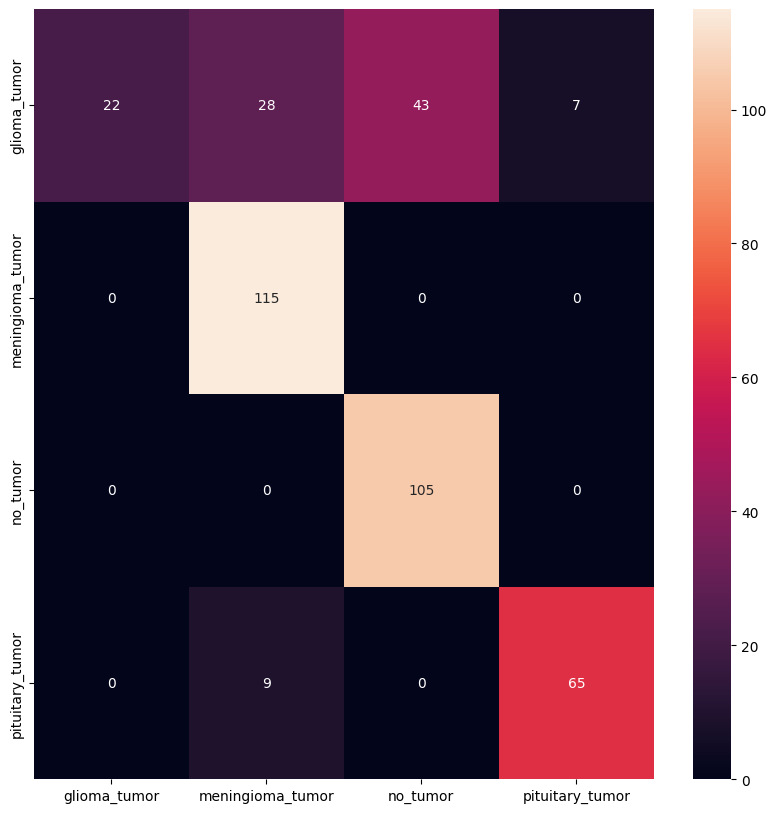

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# we plot a confusion matrix to see the performance of the model
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((4, 4))
model.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = train_dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

Our model seems to be having issues with classifying glioma tumors, but otherwise, surprisingly accurate

We can try a slightly more complicated framework using multiple convolution layers and multiple FC layers to see if a more complicated network performs better

## Attempt 2: Two-Conv and Two-FC

In [ ]:
# we try again using a more complex model, we do two convolutional layers and two fully connected layers
model_cp = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32*64*64, 128),
    nn.ReLU(),
    nn.Linear(128, 4))

# move the model to the GPU if available
model_cp.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cp.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
train_temp = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(n_epochs):
    model_cp.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_cp(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()


Epoch 1/10 - Loss: 0.7383173108100891 performed in 2.7326104640960693 seconds
Epoch 2/10 - Loss: 0.5040185451507568 performed in 5.42216157913208 seconds
Epoch 3/10 - Loss: 0.5541760921478271 performed in 8.118611574172974 seconds
Epoch 4/10 - Loss: 0.31398364901542664 performed in 10.821165323257446 seconds
Epoch 5/10 - Loss: 0.07669127732515335 performed in 13.52899432182312 seconds
Epoch 6/10 - Loss: 0.11675936728715897 performed in 16.241251468658447 seconds
Epoch 7/10 - Loss: 0.013441603630781174 performed in 18.96001434326172 seconds
Epoch 8/10 - Loss: 0.01801527850329876 performed in 21.682220458984375 seconds
Epoch 9/10 - Loss: 0.005071266088634729 performed in 24.40997838973999 seconds
Epoch 10/10 - Loss: 0.5325831174850464 performed in 27.140451431274414 seconds


In [ ]:
# test the model accuracy
correct = 0
total = 0
model_cp.eval()
test_temp = test_loader_gpu if torch.cuda.is_available() else test_loader
with torch.no_grad():
    for data, target in test_temp:
        output = model_cp(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 76.14213197969544%


We seem to have gotten more or less the same accuracy...

<Axes: >

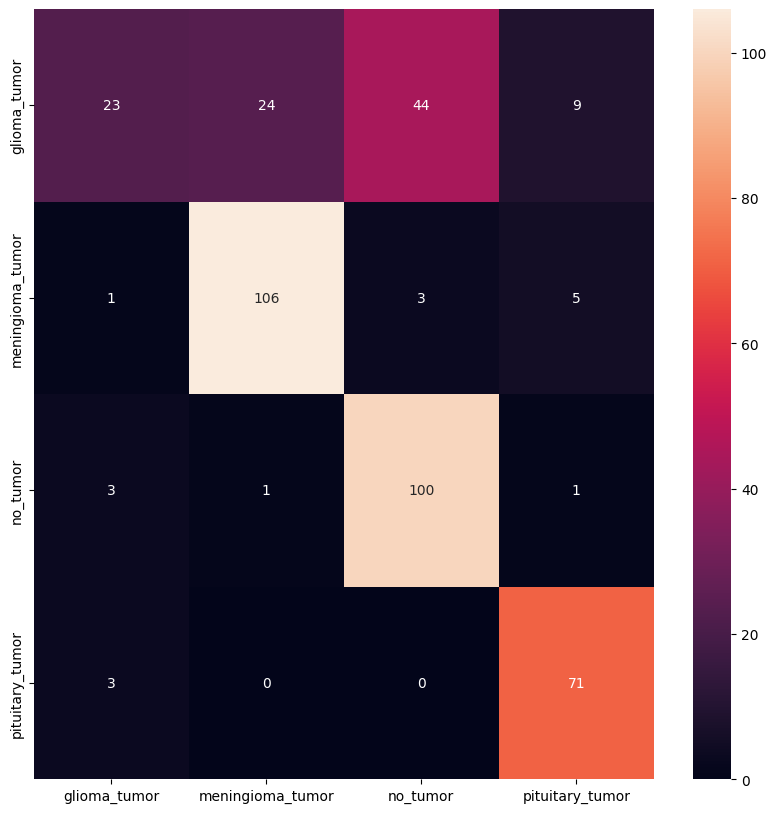

In [ ]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((4, 4))
model_cp.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_cp(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = train_dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

In [ ]:
# we can try loading the images at a higher resolution, but we should check what the minimum dimensions are
min_x = 10000
min_y = 10000

for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith('.jpg'):
            img = plt.imread(os.path.join(root, file))
            x, y = img.shape[:2]
            min_x = min(x, min_x)
            min_y = min(y, min_y)

print(min_x, min_y)

198 180


Apparently, we're already overshooting our minimum dimensions! Just to see: what happens if we resize to a smaller resolution?

## Attempt 3: Smaller Image Transform

In [ ]:
data_transform_sm = transforms.Compose(
    [transforms.Resize((128, 128)), 
    transforms.ToTensor()])

# define the new smaller datasets using ImageFolder
train_dataset_sm = datasets.ImageFolder(root=train_path, transform=data_transform_sm)
test_dataset_sm = datasets.ImageFolder(root=test_path, transform=data_transform_sm)

# define the new smaller dataloaders
train_loader_sm = DataLoader(dataset=train_dataset_sm, batch_size=32, shuffle=True)
test_loader_sm = DataLoader(dataset=test_dataset_sm, batch_size=32, shuffle=True)

# move to gpu if available
if torch.cuda.is_available():
    train_loader_gpu_sm = [(data.to(device), target.to(device)) for data, target in train_loader_sm]
    test_loader_gpu_sm = [(data.to(device), target.to(device)) for data, target in test_loader_sm]

In [ ]:
# simple CNN model with one convolutional layer and one fully connected layer
model_sm = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*64*64, 4))

# move the model to the GPU if available
model_sm.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sm.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
first_start = start_time
train_temp = train_loader_gpu_sm if torch.cuda.is_available() else train_loader_sm
for epoch in range(n_epochs):
    model_sm.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_sm(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()
print(f'Total Train Time: {time.time() - first_start} seconds')

Epoch 1/10 - Loss: 0.5091195702552795 performed in 0.354703426361084 seconds
Epoch 2/10 - Loss: 0.33319926261901855 performed in 0.3124051094055176 seconds
Epoch 3/10 - Loss: 0.24074816703796387 performed in 0.3132610321044922 seconds
Epoch 4/10 - Loss: 0.23596788942813873 performed in 0.3164024353027344 seconds
Epoch 5/10 - Loss: 0.11322317272424698 performed in 0.315108060836792 seconds
Epoch 6/10 - Loss: 0.056326281279325485 performed in 0.31434154510498047 seconds
Epoch 7/10 - Loss: 0.12041033059358597 performed in 0.3154642581939697 seconds
Epoch 8/10 - Loss: 0.12035572528839111 performed in 0.31569385528564453 seconds
Epoch 9/10 - Loss: 0.031240517273545265 performed in 0.3146400451660156 seconds
Epoch 10/10 - Loss: 0.0436045378446579 performed in 0.3156313896179199 seconds
Total Train Time: 3.1884145736694336 seconds


In [ ]:
# test the model accuracy
correct = 0
total = 0
model_sm.eval()
test_temp = test_loader_gpu_sm if torch.cuda.is_available() else test_loader_sm
with torch.no_grad():
    for data, target in test_temp:
        output = model_sm(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 77.15736040609137%


<Axes: >

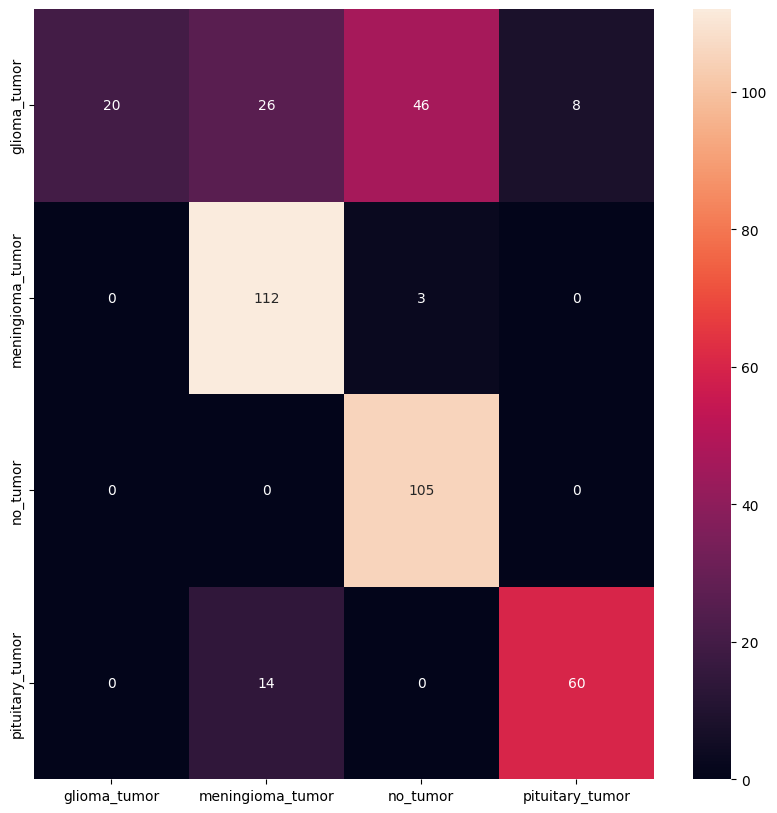

In [ ]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((4, 4))
model.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = train_dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

Since we seem to be having issues with glioma tumours specifically with confusion against no tumours, we can try a two-step
classification. First, we see if there is a tumour. Then, we classify what kind of tumour it is

## Attempt 4: Two-Step Classification

In [ ]:
# we try again, but classes 0,1,and 3 are merged into one class first
# we need to redefine the dataset and the dataloader

train_dataset_bin = datasets.ImageFolder(root=train_path, transform=data_transform_sm)
test_dataset_bin = datasets.ImageFolder(root=test_path, transform=data_transform_sm)

class_mapping = {0: 1, 1: 1, 2: 0, 3: 1}

class DatasetBinary(Dataset):
    def __init__(self, dataset, class_mapping):
        self.dataset = dataset
        self.class_mapping = class_mapping
        self.targets = [class_mapping[target] for _, target in self.dataset]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        return data, self.class_mapping[target]

train_dataset_bin = DatasetBinary(train_dataset_bin, class_mapping)
test_dataset_bin = DatasetBinary(test_dataset_bin, class_mapping)

train_loader_bin = DataLoader(dataset=train_dataset_bin, batch_size=32, shuffle=True)
test_loader_bin = DataLoader(dataset=test_dataset_bin, batch_size=32, shuffle=True)


In [ ]:
# we should check the distribution of the classes in the dataset
class_distribution = {}
for _, target in train_loader_bin:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)

train {1: 2475, 0: 395}


Huh, well the imbalance is certainly a problem. We can guard against this using a weighted sampler

In [149]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Calculate class weights as the inverse of their frequencies
class_counts = Counter(train_dataset_bin.targets)
total_samples = sum(class_counts.values())
class_weights = {class_idx: total_samples / count for class_idx, count in class_counts.items()}

# Calculate sampling weights for each instance in the dataset
sample_weights = [class_weights[target] for target in train_dataset_bin.targets]

# Define the sampler for the DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Define the DataLoader with the sampler
train_loader_bin_weighted = DataLoader(dataset=train_dataset_bin, batch_size=64, sampler=sampler)

In [152]:
# distribution of the classes in the dataset
class_distribution = {}
for _, target in train_loader_bin_weighted:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)

train {1: 1401, 0: 1469}


Looks good! We can start training

In [156]:
# move the loaders to the GPU if available
if torch.cuda.is_available():
    train_loader_gpu_bin = [(data.to(device), target.to(device)) for data, target in train_loader_bin_weighted]
    test_loader_gpu_bin = [(data.to(device), target.to(device)) for data, target in test_loader_bin]


# simple CNN model with one convolutional layer and one fully connected layer
model_bin = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*64*64, 2))

# move the model to the GPU if available
model_bin.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bin.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
first_start = start_time
train_temp = train_loader_gpu_bin if torch.cuda.is_available() else train_loader_bin
for epoch in range(n_epochs):
    model_bin.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_bin(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()
print(f'Total Train Time: {time.time() - first_start} seconds')

Epoch 1/10 - Loss: 0.48610109090805054 performed in 0.3574364185333252 seconds
Epoch 2/10 - Loss: 0.2727920413017273 performed in 0.2985563278198242 seconds
Epoch 3/10 - Loss: 0.1962360292673111 performed in 0.2989819049835205 seconds
Epoch 4/10 - Loss: 0.12725313007831573 performed in 0.30274200439453125 seconds
Epoch 5/10 - Loss: 0.08608334511518478 performed in 0.3026735782623291 seconds
Epoch 6/10 - Loss: 0.08809191733598709 performed in 0.3004567623138428 seconds
Epoch 7/10 - Loss: 0.07019316405057907 performed in 0.3003537654876709 seconds
Epoch 8/10 - Loss: 0.06544896215200424 performed in 0.30297350883483887 seconds
Epoch 9/10 - Loss: 0.047164469957351685 performed in 0.30107712745666504 seconds
Epoch 10/10 - Loss: 0.013592006638646126 performed in 0.30039429664611816 seconds
Total Train Time: 3.0662753582000732 seconds


In [157]:
# test the model accuracy
correct = 0
total = 0
model_bin.eval()
test_temp = test_loader_gpu_bin if torch.cuda.is_available() else test_loader_bin
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 77.41116751269035%


<Axes: >

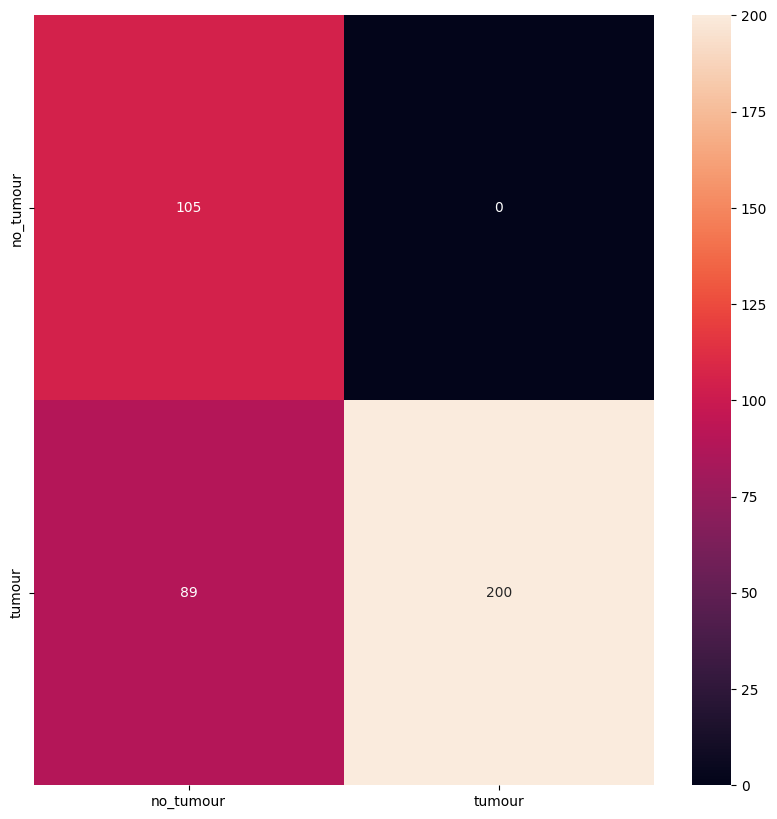

In [158]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((2, 2))
model_bin.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = ['no_tumour', 'tumour']
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

That's not great. We should try a slightly more complicated model next time, but this 2-step classification is promising

In [ ]:
# we might want to detect a tumour first, and then afterwards classify it
# we can refer to this https://github.com/kondratevakate/mri-deep-learning-tools maybe for insight or techniques
# we can also try to segment the image first to locate the tumour, then train the classifier on the segmented images



In [ ]:
torch.cuda.is_available() # check if cuda is available

True